# TSP + QAOA - naive approach

In the previous tutorials we learned what is the Traveling Salesman Problem and how to use QAOA to solve optimization problems.
<br>
Now it's finally time to solve TSP using quantum computing!

In this tutorial you will learn the following:

- How to encode TSP for QAOA

## Encoding the problem

One of the important decisions we need to make with any problem we encounter is how to encode our input and output data. What will be the good choice depends on many factors:
- what algorithm we use?
- do we have any constraints (e.g. amount of data, memory)?
- what hardware do we use?
- many others

One of the most convenient way of encoding solution to TSP is the one we used in the first part:

0 -> 1 -> 2 -> 3 , which for Python translates into `[0,1,2,3]` or `(0,1,2,3)`.

This means that we start from the city 0, then go to 1 and so on.

However, in case of quantum computers, one of the main constraints is that we need to use binary representation. Qubits can take only 0 or 1 values during the measurement, so this format won't work.

We know that at any given time we can be only in one city. Hence, for N cities we have N time slots.
<br>
Using binary representation, we could use N strings (representing time slots) of N bits (representing cities), where the active bit in each string is the city that we visit.

So in the case of [0,1,2,3] we will get the following matrix:

$\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}$

Which translates into the following string of bits:

`[1,0,0,0, 0,1,0,0, 0,0,1,0, 0,0,0,1]`


TODO: write about the problems with this encoding later

This is a little bit unwieldy, so we will use the following helper methods:

In [1]:
import numpy as np

def points_order_to_binary_state(points_order):
    """
    Transforms the order of points from the standard representation: [0, 1, 2],
    to the binary one: [1,0,0,0,1,0,0,0,1]
    """
    number_of_points = len(points_order)
    binary_state = np.zeros((len(points_order))**2)
    for j in range(len(points_order)):
        p = points_order[j]
        binary_state[(number_of_points) * (j) + (p)] = 1
    return binary_state

def binary_state_to_points_order(binary_state):
    """
    Transforms the the order of points from the binary representation: [1,0,0,0,1,0,0,0,1],
    to the binary one: [0, 1, 2]
    """
    points_order = []
    number_of_points = int(np.sqrt(len(binary_state)))
    for p in range(number_of_points):
        for j in range(number_of_points):
            if binary_state[(number_of_points) * p + j] == 1:
                points_order.append(j)
    return points_order

Let's see if it works on an example:

In [2]:
points_order = [0, 1, 2]
binary_state = points_order_to_binary_state(points_order)
points_order_again = binary_state_to_points_order(binary_state)

print("Binary representation of ", points_order, "is", binary_state)
print(points_order_again, "should be equal to", points_order)

Binary representation of  [0, 1, 2] is [1. 0. 0. 0. 1. 0. 0. 0. 1.]
[0, 1, 2] should be equal to [0, 1, 2]


## Solving TSP

Now that we know how to encode our problem, we will use `ForestTSPSolverNaive` class to solve it. We will start with 3 cities since the calcultions are faster. We will go to more cities when we are sure that our code is working properly.

In [3]:
from scripts.forest_tsp_solver_naive import ForestTSPSolverNaive

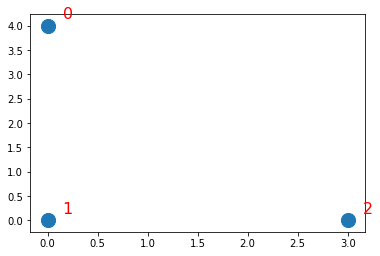

In [50]:
from scripts import utilities
from scripts import plots
import matplotlib.pyplot as plt
# cities = utilities.create_cities(3)
cities = np.array([[0, 4],[0, 0],[3, 0]])
distance_matrix = utilities.get_distance_matrix(cities)
plots.plot_cities(cities)
plt.show()

In [55]:
tsp_solver = ForestTSPSolverNaive(distance_matrix)
solution, distribution = tsp_solver.solve_tsp()

                     models will be ineffective
	Parameters: [2.83454427 4.39321418] 
	E => -325.5051577601338
	Parameters: [2.83454427 4.39321418] 
	E => -313.58433071972394
	Parameters: [2.86997607 4.39321418] 
	E => -293.38692747242794
	Parameters: [2.84340222 4.41936427] 
	E => -331.0119766508694
	Parameters: [2.84340222 4.41936427] 
	E => -330.74375096730216
	Parameters: [2.84340222 4.41936427] 
	E => -291.60214495395877
	Parameters: [2.84340222 4.41936427] 
	E => -325.9397916942484
	Parameters: [2.85115293 4.42263303] 
	E => -332.54842459343007
	Parameters: [2.85115293 4.42263303] 
	E => -332.3656568316081
	Parameters: [2.8428486  4.42099865] 
	E => -332.87299837268915
	Parameters: [2.8605645  4.42099865] 
	E => -332.0685308562693
	Parameters: [2.85142974 4.42181584] 
	E => -333.0019088661559
	Parameters: [2.85142974 4.42181584] 
	E => -332.9564648157342
	Parameters: [2.86042609 4.42140724] 
	E => -333.0143985391002
	Parameters: [2.84931905 4.42150939] 
	E => -333.0244309704239
	

(OPTIONAL) Since you might got a different solution than me, here are the angles that I got, so you can replicate my results:

In [56]:
tutorial_betas = [2.8558306]
tutorial_gammas = [4.42149024]

print("Angles you got:", tsp_solver.betas, tsp_solver.gammas)
print("Angles I got:", tutorial_betas, tutorial_gammas)

Angles you got: [2.8558306] [4.42149024]
Angles I got: [0.30371314] [4.84584598]


In [31]:
tsp_solver.betas = tutorial_betas
tsp_solver.gammas = tutorial_gammas
tsp_solver.calculate_solution()

In [57]:
solution = tsp_solver.solution
print("The solution is:", solution)

The solution is: [0, 1, 2, 2]


Wait a minute... This doesn't make sense at all. We wanted to get `[0, 1, 2]`, and I got `[0, 1, 2, 2]`.
<br>
Maybe something is wrong with the `binary_state_to_points_order` in our solver? We should investigate the binary string.

In [58]:
print("The binary solution is:", tsp_solver.most_frequent_string)

The binary solution is: (1, 1, 1, 0, 0, 0, 0, 0, 1)


This solution doesn't make sense at all! This string means, that at t=0 we are in all the cities at the same time, then at t=1 we are not present anywhere and at t=2 we are in the city 2.
<br>
It's not a surprise, that our order of traveling looks suspicious.

At this point you may have noticed something suspicious with our class. It's called `ForestTSPSolverNaive`.
<br>
"Naive"... It doesn't sound very promising to me. Let's see why I named it naive, what's actually inside it and why we got such a crappy solution.

## Creating cost operators

As you remember from the previous part, in order to make QAOA solve the problem we want, we need to translate it into its native language - language of Pauli operators.
<br>
What we need to do for the TSP is pretty similar to what we have done for MaxCut, so let's code it.

In [36]:
distance_matrix = utilities.get_distance_matrix(cities)
print(distance_matrix)
number_of_cities = len(cities)

[[0. 4. 5.]
 [4. 0. 3.]
 [5. 3. 0.]]


In [35]:
#TODO: rename number_of_nodes to number_of_cities in the script

The last time we learned two useful equations for MaxCut which will guide us now. 
<br>
One for the classical cost function:
<br>
$C_{total} = \sum C_{ij} = \sum \frac{1}{2} w_{ij} (1 - z_i z_j) $,

And one showing how to construct the quantum cost operator:
<br>
$H_{cost} = \sum \frac{1}{2} w_{ij} (\mathbb{1} - \sigma^z_i \sigma^z_j$)

However, for TSP it's a little bit more complicated, since $i$ and $j$ correspond to indices of qubits, not the indices of cities.
<br>
I tried to write a nice mathematical formula for you, but after several minutes I have not produced anything concise and elegant.

I guess that I'm so spoiled with the programming that it's much more intuitive for me to just show you how it works in code ;)


In [47]:
from pyquil.paulis import PauliTerm

cost_operators = []
number_of_nodes = len(distance_matrix)

for i in range(number_of_nodes):
    for j in range(i, number_of_nodes):
        for t in range(number_of_nodes - 1):
            weight = -distance_matrix[i][j]#/2
            if distance_matrix[i][j] != 0:
                qubit_1 = t * number_of_nodes + i
                qubit_2 = (t + 1) * number_of_nodes + j
                cost_operators.append(PauliTerm("I", 0, weight) - PauliTerm("Z", qubit_1, weight) * PauliTerm("Z", qubit_2))
                print("City", i, "to", j, "at t =", t, "costs", weight, "Qubits:", qubit_1, qubit_2)

City 0 to 1 at t = 0 costs -4.0 Qubits: 0 4
City 0 to 1 at t = 1 costs -4.0 Qubits: 3 7
City 0 to 2 at t = 0 costs -5.0 Qubits: 0 5
City 0 to 2 at t = 1 costs -5.0 Qubits: 3 8
City 1 to 2 at t = 0 costs -3.0 Qubits: 1 5
City 1 to 2 at t = 1 costs -3.0 Qubits: 4 8


There are several things going on here:
1. We have "-" sign everywhere - that's because we want to get the shortest, not the longest path.
2. We decided not to use $\frac{1}{2}$ term, it's commented. Since constants don't influence the optimization process, we can do that, though it's good to be consistent with the equations, so we will include it in the future.
3. We need to include every cost (N-1) times - once for each step between the cities. 3 time slots -> 2 steps.
4. It's hard to see right away why we use these qubits and not the others. Take your time to understand where are those two lines defining `qubit_1` and `qubit_2` coming from. Pen and paper is useful for that :)
5. We ommited terms with zeros - well, it didn't cost us anything ;)

And this is how the cost operators look like. As you can see, the `Z` terms correspond to the qubit indices above.

In [49]:
for cost_operator in cost_operators:
    print(cost_operator)

(-4+0j)*I + (4-0j)*Z0*Z4
(-4+0j)*I + (4-0j)*Z3*Z7
(-5+0j)*I + (5-0j)*Z0*Z5
(-5+0j)*I + (5-0j)*Z3*Z8
(-3+0j)*I + (3-0j)*Z1*Z5
(-3+0j)*I + (3-0j)*Z4*Z8


Ok, so this is basically the code we used (you can check out `forest_tsp_solver_naive.py` in `scripts` directory). 
But it doesn't answer the question, why the results we got don't make sense at all.

Take your time to solve this puzzle by yourself and when you are ready, go to the next section

I leave some blank space, so you can try to solve this mystery by yourself, without the next header spoiling it.
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## Spoiler-free header